# Oxygen Evals: Hood Canal-Sisters Point-Lynch Cove

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import cmocean.cm as cm
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import arrow

In [2]:
with xr.open_dataset('/ocean/atall/MOAD/grid/mesh_mask202108.nc') as mesh:
    deptht = mesh.gdept_1d[0].values
    tmask0 = mesh.tmask
    mbathy0 = mesh.mbathy
    long = mesh.nav_lon
    latg = mesh.nav_lat
with xr.open_dataset('/ocean/atall/MOAD/grid/bathymetry_202310b.nc') as bath:
    bathy = bath.Bathymetry

In [3]:
def plot_and_stats(temp1, name, idepth, jdepth, fig, ax, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    if boxes:
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3]) &
                              (temp1[obsn] == temp1[obsn])]
        shift_text = 0.94
    else:
        print (temp1.keys())
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth) & (temp1[obsn] == temp1[obsn])]
        shift_text = 1
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
    
    counts, xedges, yedges, color = ax.hist2d(select[one], 
                                              select[two], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
    fig.colorbar(color, ax=ax)
   
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
#    m, c, syst, nonsyst = slope_inter(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.5)
#    ax.plot(xr, c + m * xr, 'r-');
    ax.plot(xr, a1 + b1 * xr, 'r-')
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh
    ax.arrow(sc+vmin, bot+vmin, 0, sh-np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(sc+vmin, top+vmin, 0, -sh+np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(2*sc+vmin, bot+vmin, 0, sh-syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(2*sc+vmin, top+vmin, 0, -sh+syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(3*sc+vmin, bot+vmin, 0, sh-nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(3*sc+vmin, top+vmin, 0, -sh+nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(0.8*sc+vmin, 0.9*bot*shift_text+vmin, 'bias', rotation=90)
    ax.text(1.8*sc+vmin, 0.72*bot*shift_text+vmin-shift_text, 'systematic', rotation=90)
    ax.text(2.8*sc+vmin, 0.6*bot*shift_text+vmin-shift_text, 'non-systematic', rotation=90)
    
    ax.set_title(f'{name}, {field} {whichdepths}{string}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2, counts

def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

def crmse(rmse, bias):
    return (np.sqrt(rmse**2 - bias**2))

def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

def wolfram_perp(df, obsin, modin):
    
    mod = np.array(df[modin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    obs = np.array(df[obsin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * df[obsin]
    
    nonsyst = np.sqrt(((df[modin] - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obsin])**2).mean())
  
    return a1, b1, systematic, nonsyst
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 



def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 0
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1


In [4]:
def stats_and_plot(years, idepth, jdepth, box, boxname, whichdepths):
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    fig.suptitle(f'{boxname} Year {years[0]}-{years[-1]}')
    
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/ocean/atall/MOAD/ObsModel/202111/ObsModel_202111_pnw_{year}0101_{year}1231.csv')
              #f'/ocean/atall/MOAD/ObsModel/202111/ObsModel_202111_ctd_from_UW_{year}0101_{year}1231.csv')
    temp1 = read_pieces(pieces1)
    alltogether, counts = plot_and_stats(temp1, '202111', idepth, jdepth, fig, axs[0], whichdepths, False, '', boxes=True, box=box, boxname=boxname)


    pieces2 = []
    for year in years:
        pieces2.append(
              f'/ocean/atall/MOAD/ObsModel/202410/ObsModel_202410b_pnw_{year}0101_{year}1231.csv')
              #f'/ocean/atall/MOAD/ObsModel/202410/ObsModel_202410b_ctd_from_UW_{year}0101_{year}1231.csv')
    temp2 = read_pieces(pieces2)
    d202410, counts = plot_and_stats(temp2, '202410', idepth, jdepth, fig, axs[1], whichdepths, False, '', boxes=True, box=box, boxname=boxname)

    plot_profiles(temp1, temp2, axs[2], axs[3], box, boxname)

    alltogether = pd.concat([alltogether, d202410], axis=0)

In [5]:


def plot_profiles(temp1, temp2, ax, ax2, box, boxname):

    corn = box
    temp1['diff'] = temp1[modn] - temp1[obsn]
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3]) &
                              (temp1[obsn] == temp1[obsn])]
    ks = (select.groupby('k')[obsn].mean().index[:])
    ax.plot(select.groupby('k')[obsn].mean(), deptht[ks], 'o-', c='k', label='Obs')
    ax.plot(select.groupby('k')[modn].mean(), deptht[ks], 'o-', c='tab:red', label='202111')
    ax2.plot(select.groupby('k')['diff'].mean(), deptht[ks], '-', c='tab:red', label='202111')
    ax.fill_betweenx(deptht[ks], select[['k', modn]].groupby('k').quantile(q=0.25)[modn], select[['k', modn]].groupby('k').quantile(q=0.75)[modn], alpha=0.2, color='tab:red')
    ax2.fill_betweenx(deptht[ks], select[['k', 'diff']].groupby('k').quantile(q=0.25)['diff'], select[['k', 'diff']].groupby('k').quantile(q=0.75)['diff'], alpha=0.2, color='tab:red')
    
    temp2['diff'] = temp2[modn] - temp2[obsn]
    select = temp2[(temp2.k >= idepth) & (temp2.k <= jdepth) &
                              (temp2.j >= corn[0]) & (temp2.j <= corn[1]) &
                              (temp2.i >= corn[2]) & (temp2.i <= corn[3]) &
                              (temp2[obsn] == temp2[obsn])]
    #ks = (select.groupby('k')[obsn].mean().index[:])
    ax.plot(select.groupby('k')[modn].mean(), deptht[ks], 'o-', c='tab:blue', label='202410')
    ax2.plot(select.groupby('k')['diff'].mean(), deptht[ks], '-', c='tab:blue', label='202410')
    ax.fill_betweenx(deptht[ks], select[['k', modn]].groupby('k').quantile(q=0.25)[modn], select[['k', modn]].groupby('k').quantile(q=0.75)[modn], alpha=0.2, color='tab:blue')
    ax.fill_betweenx(deptht[ks], select[['k', obsn]].groupby('k').quantile(q=0.25)[obsn], select[['k', obsn]].groupby('k').quantile(q=0.75)[obsn], alpha=0.2, color='k')
    ax2.fill_betweenx(deptht[ks], select[['k', 'diff']].groupby('k').quantile(q=0.25)['diff'], select[['k', 'diff']].groupby('k').quantile(q=0.75)['diff'], alpha=0.2, color='tab:blue')
    
    ax.invert_yaxis()
    ax2.invert_yaxis()
    
    ax.legend()
    ax2.legend()
    ax.set_title(f'{field} Profiles')
    ax2.set_title(f'{field} Difference Profiles')
    ax2.grid();

In [6]:
d202410_14 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202410/ObsModel_202410b_pnw_20140101_20141231.csv')
d202410_15 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202410/ObsModel_202410b_pnw_20150101_20151231.csv')
d202410_16 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202410/ObsModel_202410b_pnw_20160101_20161231.csv')
d202410_17 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202410/ObsModel_202410b_pnw_20170101_20171231.csv')
d202410_18 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202410/ObsModel_202410b_pnw_20180101_20181231.csv')
d202410_19 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202410/ObsModel_202410_pnw_20190101_20191231.csv')
d202410_20 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202410/ObsModel_202410_pnw_20200101_20201231.csv')
d202410_21 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202410/ObsModel_202410_pnw_20210101_20211231.csv')
d202410_22 = pd.read_csv('/ocean/atall/MOAD/ObsModel/202410/ObsModel_202410_pnw_20220101_20221231.csv')

d202410 = pd.concat([d202410_14, d202410_15, d202410_16, d202410_17, d202410_18, d202410_19, d202410_20, d202410_21, d202410_22
                       ], ignore_index=True)
d202410

,Unnamed: 0.1,Unnamed: 0,dtUTC,Lon,Lat,Z,pressure (dbar),Temp,SA,Oxygen_Dissolved,...,i,mod_vosaline,mod_votemper,mod_dissolved_oxygen,k,mod_nitrate,mod_silicon,mod_ammonium,mod_diatoms,mod_flagellates
0,0,1221179,2014-01-01,-125.15,49.06,29.0,28.883333,NaN,32.226162,NaN,...,16,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN
1,1,1221180,2014-01-01,-125.15,49.06,30.0,30.304400,NaN,32.236803,NaN,...,16,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN
2,2,1221181,2014-01-01,-125.15,49.06,31.0,31.747571,NaN,32.230564,NaN,...,16,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN
3,3,1221182,2014-01-01,-125.15,49.06,32.0,32.528000,NaN,32.240771,NaN,...,16,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN
4,4,1221183,2014-01-01,-125.15,49.06,68.0,68.978231,NaN,32.556446,NaN,...,16,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277584,31444,2217001,2022-12-30,-125.00,48.97,6.0,6.000000,8.219548,30.784250,NaN,...,26,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN
277585,31445,2217000,2022-12-30,-125.24,50.02,8.0,8.000000,8.375991,30.082221,NaN,...,122,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN
277586,31446,2217009,2022-12-30,-124.77,49.49,21.0,21.000000,7.891460,29.770961,NaN,...,125,29.461060,6.768876,234.290024,19,32.691608,49.552479,3.596281,0.140007,0.137015
277587,31447,2217010,2022-12-30,-124.77,49.49,42.0,42.000000,7.956260,29.898826,NaN,...,125,29.492071,6.338597,242.106857,23,32.455406,49.469120,3.729292,0.125351,0.119035


/tmp/ipykernel_1806558/1756228326.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0].pcolormesh(long, latg, bathy, cmap=cm.deep, vmin=0, vmax=100)
/tmp/ipykernel_1806558/1756228326.py:19: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im=ax[1].pcolormesh(long, latg, bathy, cmap=cm.deep, vmin=0, vmax=100)


Text(0, 0.5, 'Depth [m]')

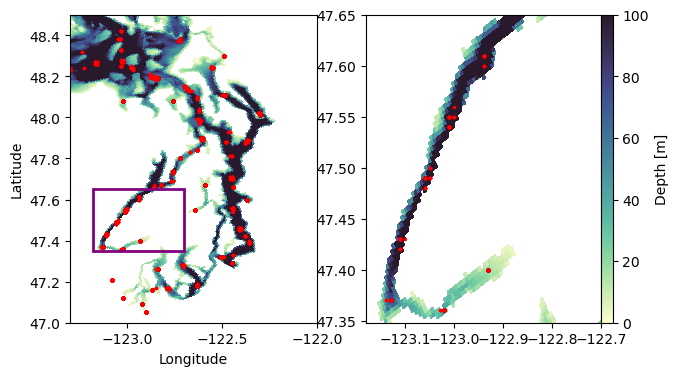

In [7]:
lon1, lon2 = (-123.18, -122.7)
lat1, lat2 = (47.348, 47.65)
fig, ax = plt.subplots(1,2,figsize=(7, 4))
ax[0].pcolormesh(long, latg, bathy, cmap=cm.deep, vmin=0, vmax=100)
ax[0].set_ylabel('Latitude')
ax[0].set_xlabel('Longitude')
ax[0].set_ylim([47,48.5])
ax[0].set_xlim([-123.3,-122])
# plot the location of observations
ax[0].scatter(d202410.Lon, d202410.Lat, color='r', s=2)
left, bottom, width, height = (lon2, lat1, lon1-lon2, lat2-lat1)
rect=mpatches.Rectangle((left,bottom),width,height, 
                    fill=False,
                    color="purple",
                    linewidth=2,
                    label="Puget Sound")
  
ax[0].add_patch(rect)
im=ax[1].pcolormesh(long, latg, bathy, cmap=cm.deep, vmin=0, vmax=100)
ax[1].set_ylim([lat1,lat2])
ax[1].set_xlim([lon1,lon2])
ax[1].scatter(d202410.Lon, d202410.Lat, color='r', s=2)


divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.002)
cbar=fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.set_ylabel('Depth [m]')


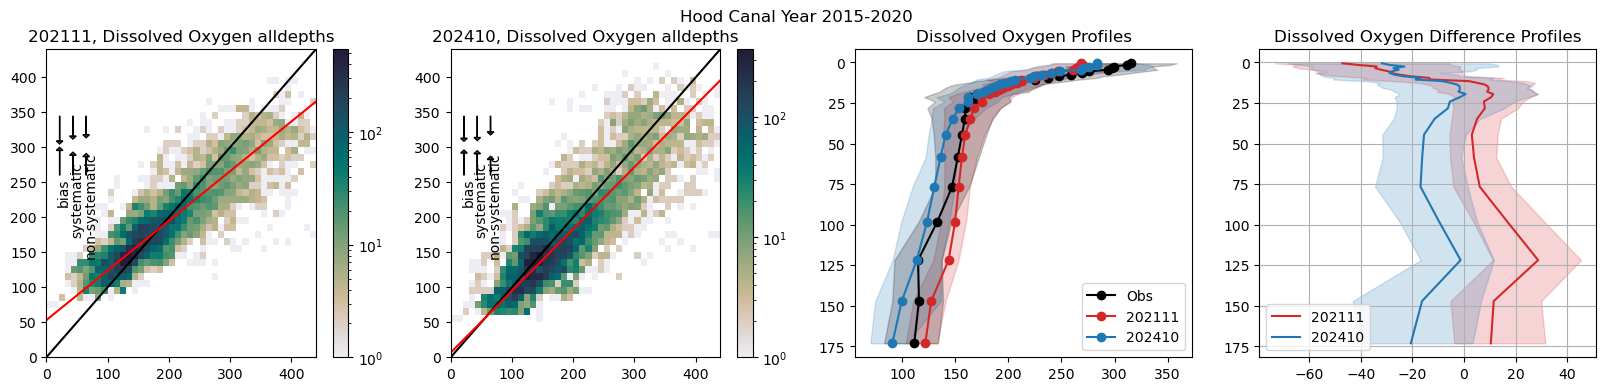

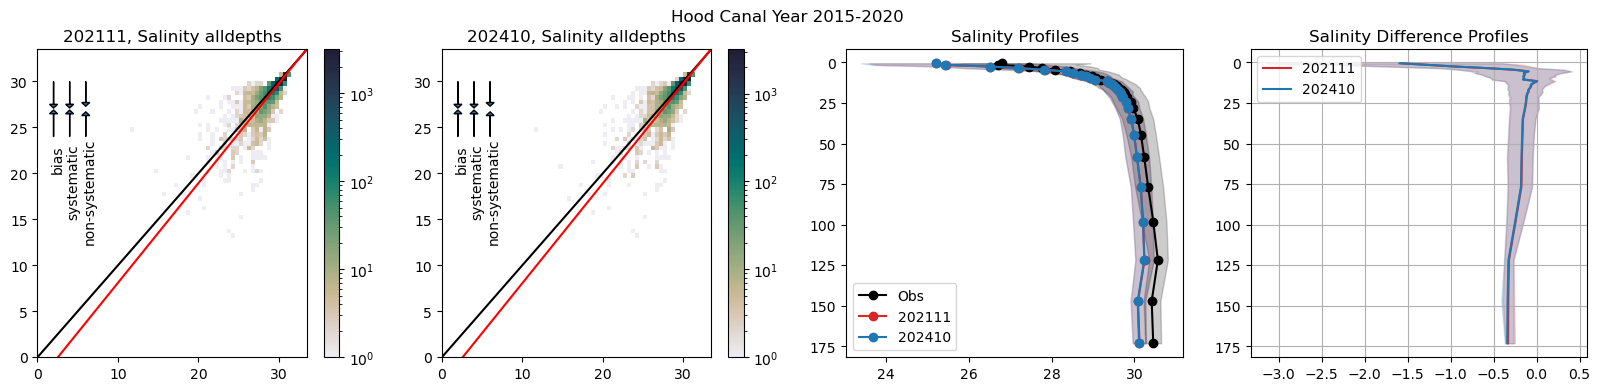

In [8]:
cmap = cm.rain #'pink_r'#cm.rain #cm.ice_r #'ocean_r' #'pink_r'
Hood_Canal = [75, 150, 90, 200]
idepth = 0
jdepth = 39

field = 'Dissolved Oxygen'
obsn = 'Oxygen_Dissolved'
modn = 'mod_dissolved_oxygen'
vmax = 450
vmin = 0
dbin = 10
scale = 260
stats_and_plot([2015,2016,2017,2018,2019,2020],
               idepth, jdepth, Hood_Canal, 'Hood Canal', 'alldepths')

field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 0
dbin = 0.5
scale = 24

stats_and_plot([2015,2016,2017,2018,2019,2020],
               idepth, jdepth, Hood_Canal, 'Hood Canal', 'alldepths')

### About Lynch Cove and Sisters point

In [9]:
HC24 = d202410[ d202410['Lon'].between(lon1, lon2) & d202410['Lat'].between(lat1, lat2) ]
SP24 = d202410[ d202410['Lon'].between(-123.1, -122.95) & d202410['Lat'].between(lat1, 47.43) ]
LC24 = d202410[ d202410['Lon'].between(-122.95, lon2) & d202410['Lat'].between(lat1, 47.43) ]

In [10]:
SP24["dtUTC"] = pd.to_datetime(SP24["dtUTC"], errors='coerce')
LC24["dtUTC"] = pd.to_datetime(LC24["dtUTC"], errors='coerce')

/tmp/ipykernel_1806558/1678761734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SP24["dtUTC"] = pd.to_datetime(SP24["dtUTC"], errors='coerce')
/tmp/ipykernel_1806558/1678761734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LC24["dtUTC"] = pd.to_datetime(LC24["dtUTC"], errors='coerce')


Text(0.5, 1.0, 'Lynch Cove')

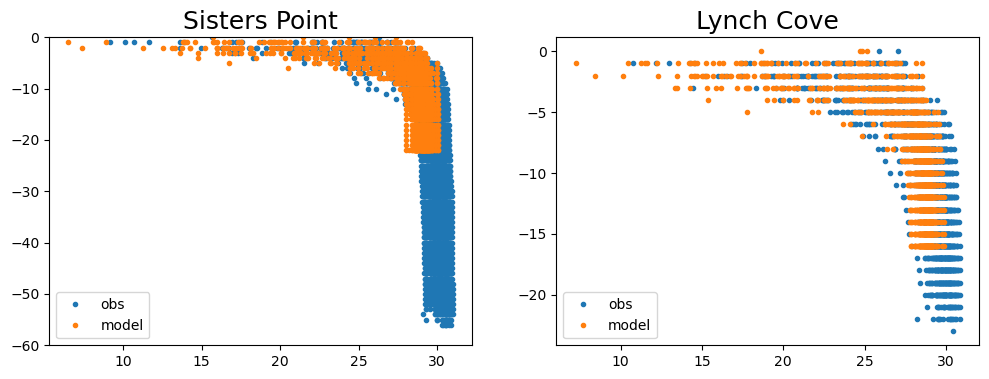

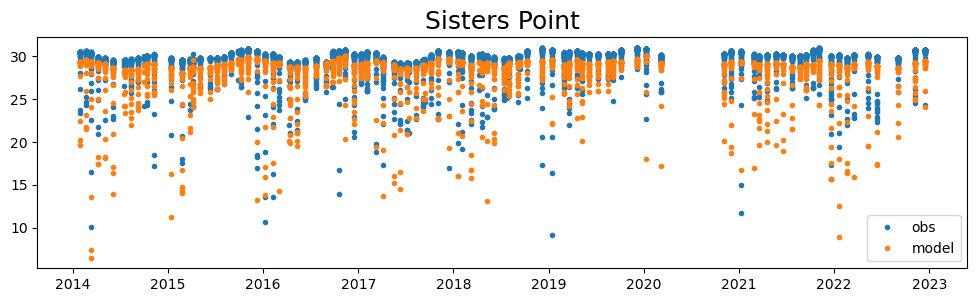

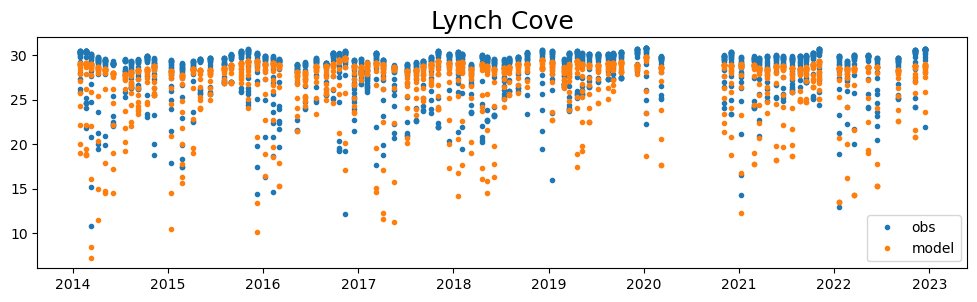

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(SP24.SA,-SP24.Z, '.',label='obs')
ax[0].plot(SP24.mod_vosaline,-SP24.Z, '.', label='model')
ax[0].set_title('Sisters Point',fontsize=18)
ax[0].set_ylim(-60,0)
ax[1].plot(LC24.SA,-LC24.Z, '.',label='obs')
ax[1].plot(LC24.mod_vosaline,-LC24.Z, '.', label='model')
ax[0].legend()
ax[1].legend()
ax[1].set_title('Lynch Cove',fontsize=18)
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(SP24.dtUTC,SP24.SA, '.',label='obs')
ax.plot(SP24.dtUTC,SP24.mod_vosaline, '.', label='model')
ax.legend()
ax.set_title('Sisters Point',fontsize=18)
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(LC24.dtUTC,LC24.SA, '.',label='obs')
ax.plot(LC24.dtUTC,LC24.mod_vosaline, '.', label='model')
ax.legend()
ax.set_title('Lynch Cove',fontsize=18)

Text(0.5, 1.0, 'Lynch Cove')

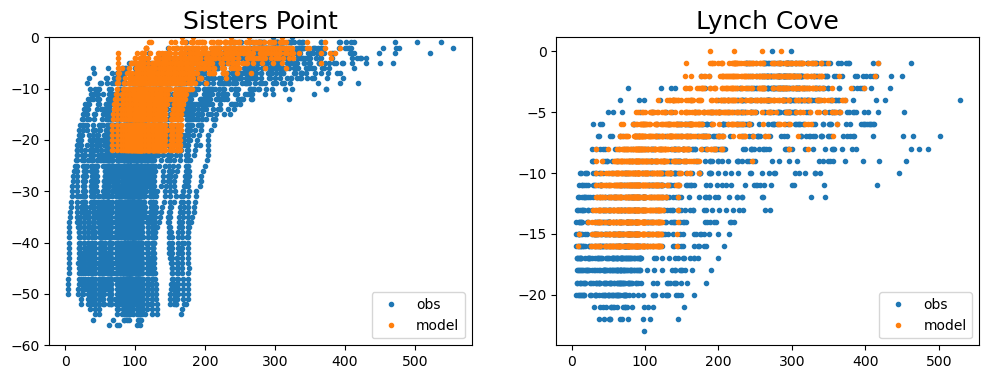

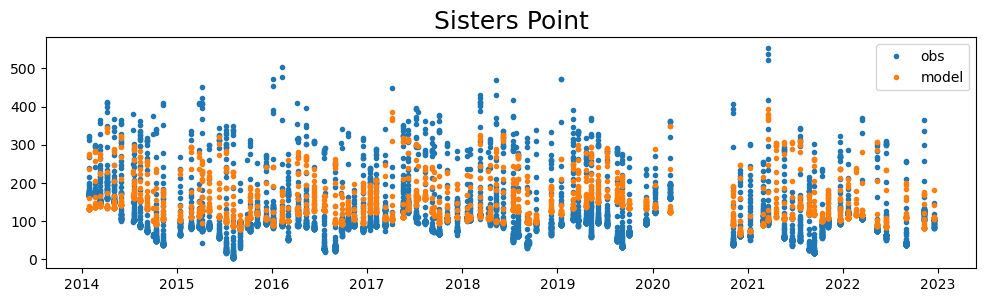

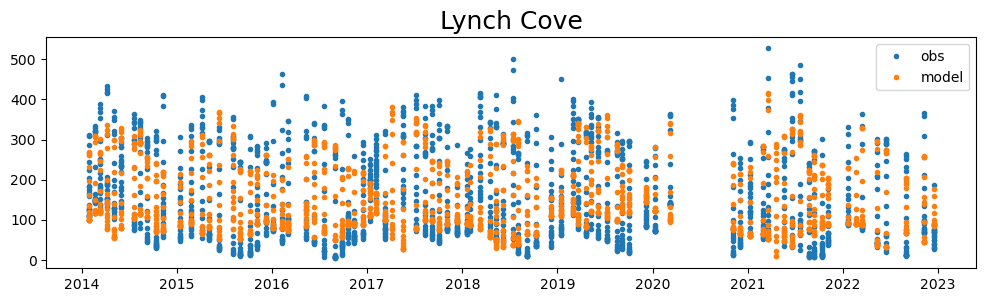

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(SP24.Oxygen_Dissolved,-SP24.Z, '.',label='obs')
ax[0].plot(SP24.mod_dissolved_oxygen,-SP24.Z, '.', label='model')
ax[0].set_title('Sisters Point',fontsize=18)
ax[0].set_ylim(-60,0)
ax[1].plot(LC24.Oxygen_Dissolved,-LC24.Z, '.',label='obs')
ax[1].plot(LC24.mod_dissolved_oxygen,-LC24.Z, '.', label='model')
ax[0].legend()
ax[1].legend()
ax[1].set_title('Lynch Cove',fontsize=18)
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(SP24.dtUTC,SP24.Oxygen_Dissolved, '.',label='obs')
ax.plot(SP24.dtUTC,SP24.mod_dissolved_oxygen, '.', label='model')
ax.legend()
ax.set_title('Sisters Point',fontsize=18)
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(LC24.dtUTC,LC24.Oxygen_Dissolved, '.',label='obs')
ax.plot(LC24.dtUTC,LC24.mod_dissolved_oxygen, '.', label='model')
ax.legend()
ax.set_title('Lynch Cove',fontsize=18)

#### Model bathymetry is shallower: compare with the nearest deeper pixel

In [13]:
grid_dir = Path("/ocean/atall/MOAD/grid/")
grid_map = Path("grid_from_lat_lon_mask999.nc")
grid_lons_lats = xr.open_dataset(grid_dir / grid_map)

In [14]:
j_Sis = grid_lons_lats.jj.sel(lats=47.356205, lons=-123.02487, method='nearest') # 37 m (Obs)
i_Sis = grid_lons_lats.ii.sel(lats=47.356205, lons=-123.02487, method='nearest')
j_LyC = grid_lons_lats.jj.sel(lats=47.39814833, lons=-122.92959167, method='nearest') # 19 m (Obs)
i_LyC = grid_lons_lats.ii.sel(lats=47.39814833, lons=-122.92959167, method='nearest')
print(bathy[j_Sis, i_Sis+1], bathy[j_LyC, i_LyC-1])
i_Sis = i_Sis+1
i_LyC = i_LyC-2

<xarray.DataArray 'Bathymetry' ()>
array(48.3125)
Coordinates:
    lons     float64 -123.0
    lats     float64 47.36
Attributes:
    units:      metres
    long_name:  sea_floor_depth <xarray.DataArray 'Bathymetry' ()>
array(20.6875)
Coordinates:
    lons     float64 -122.9
    lats     float64 47.4
Attributes:
    units:      metres
    long_name:  sea_floor_depth


Text(0.5, 1.0, 'Obs-Lynch Cove')

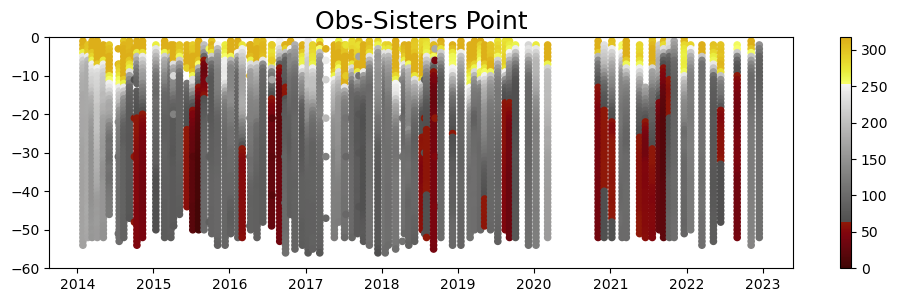

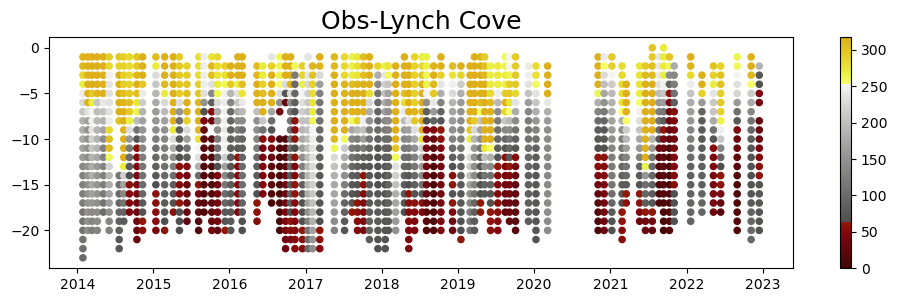

In [15]:

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
sc = ax.scatter(SP24.dtUTC, -SP24.Z, c=SP24.Oxygen_Dissolved, vmin=0, vmax=317, s=20, cmap=cm.oxy)
plt.colorbar(sc)
ax.set_ylim(-60,0)
ax.set_title('Obs-Sisters Point',fontsize=18)
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
sc = ax.scatter(LC24.dtUTC, -LC24.Z, c=LC24.Oxygen_Dissolved, vmin=0, vmax=317, s=20, cmap=cm.oxy)
plt.colorbar(sc)
ax.set_title('Obs-Lynch Cove',fontsize=18)

In [ ]:
syear = 2020
eyear = 2022
smonth = 8
emonth = 12
startdate = arrow.get(syear, smonth, 1)
enddate = arrow.get(eyear, emonth, 31)
dir = '/ocean/sallen/timbucktwo/oxygen/'
for ii in range(2):
    fig, axs = plt.subplots(1, 1, figsize=(12, 3))
    if ii==0:
        KK, JJ, II = (np.array(mbathy0[0,j_Sis,i_Sis]), j_Sis, i_Sis)
    else:
        KK, JJ, II = (np.array(mbathy0[0,j_LyC,i_LyC]), j_LyC, i_LyC)
    first=True
    for iii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
        year = day.year
        yr2 = day.strftime("%y")
        month = day.month
        Month = day.strftime("%b").lower()
        day = day.day
        # set up filename to follow NEMO conventions
        fgrdT = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_grid_T.nc'
        with xr.open_dataset(fgrdT) as ds_grdT:
            sal0 = ds_grdT['vosaline'][:,:KK,JJ,II]
        if first:
            first = False
            sal = sal0
        else:
            sal = xr.concat([sal, sal0], dim='time_counter')
    sal.plot(ax=axs, y="deptht",yincrease=False, vmin=15, vmax=30, cmap=cm.haline)
    if ii==0:
        axs.scatter(SP24.dtUTC, SP24.Z, c=SP24.SA, vmin=15, vmax=30, s=20, cmap=cm.haline, edgecolor='r')
        axs.set_title('Sisters Point',fontsize=18)
    else:
        axs.scatter(LC24.dtUTC, LC24.Z, c=LC24.SA, vmin=15, vmax=30, s=20, cmap=cm.haline, edgecolor='r')
        axs.set_title('Lynch Cove',fontsize=18)


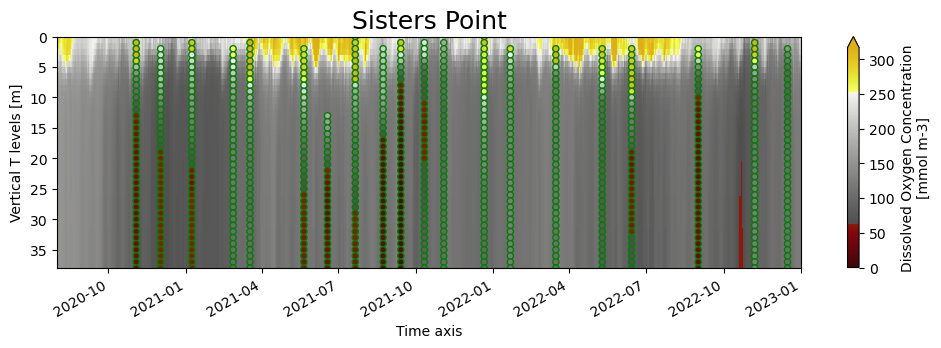

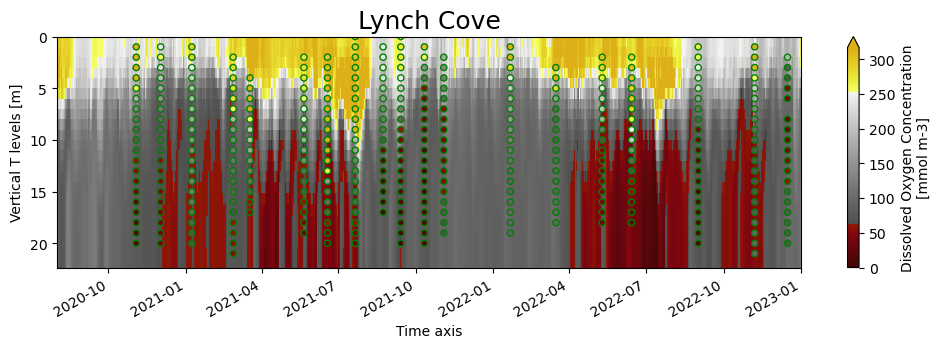

In [ ]:
syear = 2020
eyear = 2022
smonth = 8
emonth = 12
startdate = arrow.get(syear, smonth, 1)
enddate = arrow.get(eyear, emonth, 31)
dir = '/ocean/sallen/timbucktwo/oxygen/'
for ii in range(2):
    fig, axs = plt.subplots(1, 1, figsize=(12, 3))
    if ii==0:
        KK, JJ, II = (np.array(mbathy0[0,j_Sis,i_Sis]), j_Sis, i_Sis)
    else:
        KK, JJ, II = (np.array(mbathy0[0,j_LyC,i_LyC]), j_LyC, i_LyC)
    first=True
    for iii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
        year = day.year
        yr2 = day.strftime("%y")
        month = day.month
        Month = day.strftime("%b").lower()
        day = day.day
        # set up filename to follow NEMO conventions
        fchem = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_chem_T.nc'
        with xr.open_dataset(fchem) as ds_chem:
            oxy0 = ds_chem['dissolved_oxygen'][:,:KK,JJ,II]
        if first:
            first = False
            oxy = oxy0
        else:
            oxy = xr.concat([oxy, oxy0], dim='time_counter')
    oxy.plot(ax=axs, y="deptht",yincrease=False, vmin=0, vmax=317, cmap=cm.oxy)
    if ii==0:
        axs.scatter(SP24.dtUTC, SP24.Z, c=SP24.Oxygen_Dissolved, vmin=0, vmax=317, s=20, cmap=cm.oxy, edgecolor='g')
        axs.set_title('Sisters Point',fontsize=18)
    else:
        axs.scatter(LC24.dtUTC, LC24.Z, c=LC24.Oxygen_Dissolved, vmin=0, vmax=317, s=20, cmap=cm.oxy, edgecolor='g')
        axs.set_title('Lynch Cove',fontsize=18)
